<h1>HW 4</h1>
Matt Buchovecky  
Astro 283

<h3>Reperform the fit and do a source subtraction again</h3>

In [56]:
import numpy
from astropy.io import fits 
from scipy import optimize, ndimage
from matplotlib import pyplot 
%matplotlib inline 



In [4]:
star_fits = fits.open("./hw3prob1-data.fits")
star_data = star_fits[0].data
star_rav = star_data.ravel()


In [5]:
def symm_2d_gaussian(pos, F, xc, yc, sigma, B):
    return F*numpy.exp(-((pos[0]-xc)**2+(pos[1]-yc)**2)/(2*sigma**2)) + B
    

In [112]:
x_bins = star_data.shape[0]
y_bins = star_data.shape[1]

# Create x and y indices
x_arr = numpy.linspace(0, x_bins-1, x_bins)
y_arr = numpy.linspace(0, y_bins-1, y_bins)
x_arr, y_arr = numpy.meshgrid(x_arr, y_arr)
coords = x_arr, y_arr

x_rav = x_arr.ravel()
y_rav = y_arr.ravel()

pi = numpy.pi

In [7]:
init_guess = (50, 130, 130, 20, 100)
sigma_array = numpy.sqrt(star_data)
p_opt_singl, p_cov_singl = optimize.curve_fit(symm_2d_gaussian, (x_rav, y_rav), star_rav, init_guess, sigma_array.ravel())


/Users/mbuchove/Programs/Anaconda3/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


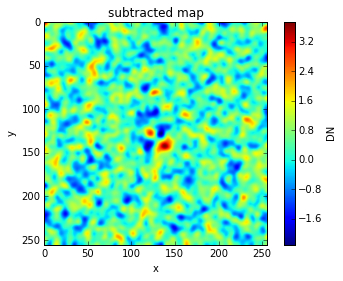

In [66]:
blank_sky = star_data - symm_2d_gaussian((x_arr,y_arr), *p_opt_singl)
smoothed_sub = ndimage.gaussian_filter(blank_sky, 3)
pyplot.imshow(smoothed_sub)
sub_plot = pyplot.imshow(smoothed_sub)
pyplot.xlabel('x')
pyplot.ylabel('y')
pyplot.title("subtracted map")
cbar = pyplot.colorbar(label='DN')
#cbar.solids.set_edgecolors('face')


<h4>Chi squared test on subtraction</h4>

In [49]:
def chi_square_(function, params, x_vals, data_vals, var_vals):
    residuals = (data_vals - function(x_vals, *params))
    chis = (residuals**2)/abs(var_vals)
    chi_sum = numpy.sum(chis)
    d_o_f = len(x_vals[0]) - len(params)
    return (chi_sum, d_o_f)


In [111]:
cs_singl, dof_singl = chi_square_(symm_2d_gaussian, p_opt_singl, (x_rav,y_rav), star_rav, star_rav)
red_cs_singl = cs_singl / dof_singl
print(red_cs_singl)


0.334679792458


<h4>Try to fit binary star</h4>

In [83]:
def binary_star(pos, F1, F2, xc, yc, rad, theta, sigma, B):
    f1 = F1*numpy.exp(-((pos[0]-(xc+rad*numpy.cos(theta)))**2+(pos[1]-(yc+rad*numpy.sin(theta)))**2)/(2*sigma**2))
    f2 = F2*numpy.exp(-((pos[0]-(xc-rad*numpy.cos(theta)))**2+(pos[1]-(yc-rad*numpy.sin(theta)))**2)/(2*sigma**2))
    return f1 + f2 + B
# should my radius be double this ?

In [48]:

sigma_array = numpy.sqrt(star_data)
sigma_rav = sigma_array.ravel()
bin_guess = (p_opt_singl[0]/2, p_opt_singl[0]/2, p_opt_singl[1], p_opt_singl[2], 5., numpy.pi/4., p_opt_singl[3], p_opt_singl[4])
p_opt_bin, p_cov_bin = optimize.curve_fit(binary_star, (x_rav,y_rav), star_rav, bin_guess, sigma_rav)

print(p_opt_bin)
print(p_cov_bin)


[  10.80603297   25.34271199  128.39125653  134.79728966    5.97064099
    0.77155851    6.11453469  133.0126394 ]
[[  1.95519089e+00  -6.27838234e-01  -4.57920283e-01  -4.45138775e-01
   -1.97182571e-01   4.25715397e-05  -1.24402940e-01   5.70375714e-04]
 [ -6.27838234e-01   1.57971650e+00   3.48449610e-01   3.38582061e-01
    2.41516919e-01  -3.68360354e-05  -7.32400540e-02  -1.78197840e-04]
 [ -4.57920283e-01   3.48449610e-01   2.26171076e-01   1.57178842e-01
    1.18717116e-01  -7.16291023e-03   1.66254296e-02  -3.12281637e-04]
 [ -4.45138775e-01   3.38582061e-01   1.57178842e-01   2.17113036e-01
    1.15264991e-01   7.30994145e-03   1.61875597e-02  -3.04169280e-04]
 [ -1.97182571e-01   2.41516919e-01   1.18717116e-01   1.15264991e-01
    1.14238732e-01  -2.37897997e-05   3.99607950e-03  -3.28262141e-04]
 [  4.25715397e-05  -3.68360354e-05  -7.16291023e-03   7.30994145e-03
   -2.37897997e-05   3.20097624e-03   4.43930505e-07  -3.94378347e-08]
 [ -1.24402940e-01  -7.32400540e-02   1

In [110]:
cs_bin, dof_bin = chi_square_(binary_star, p_opt_bin, (x_rav,y_rav), star_rav, star_rav)
red_cs_bin = cs_bin / dof_bin
print( red_cs_bin)


0.33426930894


<h4>Likelihood ratio test</h4>

In [115]:
F_max = 300 # DN
pix_width = len(x_arr[0])
param_diff = len(p_opt_bin) - len(p_opt_singl)
chi_s_diff = cs_singl - cs_bin
det_pcov_bin = numpy.linalg.det(p_cov_bin)
det_pcov_singl = numpy.linalg.det(p_cov_singl)

likelihood_ratio = numpy.power(2*pi, param_diff/2) / (pi * F_max * pix_width) * numpy.sqrt(det_pcov_bin/det_pcov_singl) * numpy.exp(chi_s_diff)
print(likelihood_ratio)

1982526.44657


<h3>Find the joint marginal distributions</h4>

In [84]:
def joint_marginal_dist(param_vals, opt_param_vals, cov_mat):
    for obj in [param_vals, opt_param_vals, cov_mat]:
        if type(cov_mat) is not numpy.matrix:
            cov_mat = numpy.matrix(cov_mat)
        vec = numpy.matrix(param_vals - opt_param_vals)
    return 1/((2*numpy.pi)*numpy.sqrt(numpy.linalg.det(cov_mat)))*numpy.exp(-0.5*vec.T*cov_mat.I*vec)
# mat1 * mat2 equivalent to numpy.dot(mat1, mat2)

<h5>Fluxes</h5>

In [86]:
F_points = 100
F1_arr = numpy.linspace(p_opt_bin[0]-5*p_cov_bin[0][0], p_opt_bin[0]+5*p_cov_bin[0][0], F_points)
F2_arr = numpy.linspace(p_opt_bin[1]-5*p_cov_bin[1][1], p_opt_bin[1]+5*p_cov_bin[1][1], F_points)

F1_arr, F2_arr = numpy.meshgrid(F1_arr, F2_arr)
coords = F1_arr, F2_arr

F1_rav = F1_arr.ravel()
F2_rav = F2_arr.ravel()


In [87]:
F0_matrix = numpy.matrix([[p_opt_bin[0]], [p_opt_bin[1]]])
sigma_F = p_cov_bin[0:2,0:2] # gets the mini 2x2 subarray 
F_rav_len = len(F1_rav)

if len(F1_rav) == F_points**2:
    fluxes_jm_prob_rav = numpy.zeros(F_rav_len)
    for i in range(0, F_rav_len):
        fluxes_jm_prob_rav[i] = joint_marginal_dist([[F1_rav[i]], [F2_rav[i]]], F0_matrix, sigma_F)


/Users/mbuchove/Programs/Anaconda3/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


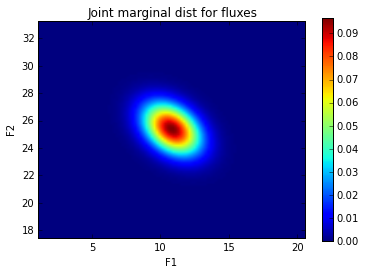

In [98]:
ext = [F1_arr.min(), F1_arr.max(), F2_arr.min(), F2_arr.max()]
pyplot.imshow(fluxes_jm_prob_rav.reshape(F_points, F_points), origin='lower', extent=ext) 
# origin='lower' to make standard x and y indices 
pyplot.title("Joint marginal dist for fluxes")
pyplot.xlabel("F1")
pyplot.ylabel("F2")
pyplot.colorbar()

In [99]:
l_points = 100
theta_arr = numpy.linspace(p_opt_bin[4]-5*p_cov_bin[4][4], p_opt_bin[4]+5*p_cov_bin[4][4], l_points)
r_arr = numpy.linspace(p_opt_bin[5]-5*p_cov_bin[5][5], p_opt_bin[5]+5*p_cov_bin[5][5], l_points)

theta_arr, r_arr = numpy.meshgrid(theta_arr, r_arr)

theta_rav = theta_arr.ravel()
r_rav = r_arr.ravel()


In [100]:
rtheta_matrix = numpy.matrix([[p_opt_bin[4]], [p_opt_bin[5]]])
sigma_rtheta = p_cov_bin[4:6,4:6] # gets the mini 2x2 subarray 
theta_rav_len = len(theta_rav)

if len(theta_rav) == l_points**2:
    rtheta_jm_prob_rav = numpy.zeros(theta_rav_len)
    for i in range(0, theta_rav_len):
        rtheta_jm_prob_rav[i] = joint_marginal_dist([[theta_rav[i]], [r_rav[i]]], rtheta_matrix, sigma_rtheta)


[5.3994473271760182, 6.541834645497616, 0.7555536261095871, 0.7875633884827441]


/Users/mbuchove/Programs/Anaconda3/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


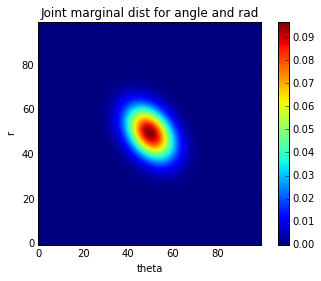

In [103]:
ext = [theta_arr.min(), theta_arr.max(), r_arr.min(), r_arr.max()]
print(ext)
pyplot.imshow(fluxes_jm_prob_rav.reshape(l_points, l_points), origin='lower') # , extent=ext
# origin='lower' to make standard x and y indices 
pyplot.title("Joint marginal dist for angle and rad")
pyplot.xlabel("theta")
pyplot.ylabel("r")
pyplot.colorbar()


In [55]:
def binary_star_0(pos, F1, xc1, yc1, sigma1, F2, xc2, yc2, sigma2, B):
    return F1*numpy.exp(-((pos[0]-xc1)**2+(pos[1]-yc1)**2)/(2*sigma1**2)) + F2*numpy.exp(-((pos[0]-xc2)**2+(pos[1]-yc2)**2)/(2*sigma2**2)) + B
    
init_guess_0 = (11., 130, 130, 15, 25., 130, 130, 15, 100)
p_opt_bin_0, p_cov_bin_0 = optimize.curve_fit(binary_star_0, (x_rav, y_rav), star_rav, init_guess_0, sigma_rav)

print(p_opt_bin_0)

[ 10737.57867108 -35655.22192769  44866.33981918  -9893.32948898
 -12004.3385579   34715.12419695 -41997.24533268  11884.02262157
    133.45548327]


In [52]:
from functools import partial
#part_func = partial(symm_2d_gaussian, pos)

# do it the simple way 
chi_s = numpy.sum(blank_sky**2/star_data)
dof = len(x_rav) - len(p_opt_singl)
print(chi_s / dof)

0.334679792458


In [ ]:
k = 3.0 # gain 
star_data_pe = k * star_data
